In [3]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Get current working directory and project root directory
cwd = os.getcwd()
wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not wd.endswith('stochastic-travel-demand-modelling'):
    wd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if wd not in sys.path:
    sys.path.append(wd)

from models.singly_constrained.spatial_interaction_model import SpatialInteraction

# Fix seed
np.random.seed(885)

# Import data

In [4]:
# Select dataset
dataset = 'commuter_ward' # 'retail', 'commuter_ward', 'commuter_borough'

# Select cost matrix type
cost_matrix_file = 'sn'
if cost_matrix_file == 'sn':
    cost_matrix_file = '_small_network'

# Select model
constrained = 'singly'

In [15]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(wd,f'data/input/{dataset}/cost_matrix{cost_matrix_file}.txt'))
origin_supply = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

# Normalise origin supply, cost matrix and destination sizes
o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

# Get origin and destination locations
origin_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/origin_locations.txt'))
destination_locs = np.loadtxt(os.path.join(wd,f'./data/input/{dataset}/destination_locations.txt'))

# Read Laplace optimisation parameters
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis{cost_matrix_file}_gamma_10000_parameters.json') as json_file:
    laplace_low_noise_opt_params = json.load(json_file)
with open(f'../data/output/{dataset}/laplace/figures/{constrained}_laplace_analysis{cost_matrix_file}_gamma_100_parameters.json') as json_file:
    laplace_high_noise_opt_params = json.load(json_file)
    
# Get dimensions
N,M = cost_matrix.shape

# Construct parameter vector for low noise regime
alpha1 = laplace_low_noise_opt_params['fitted_alpha']
beta1 = laplace_low_noise_opt_params['fitted_scaled_beta']
theta_low_noise = np.array([alpha1,beta1])

# Construct parameter vector for high noise regime
alpha2 = laplace_high_noise_opt_params['fitted_alpha']
beta2 = laplace_high_noise_opt_params['fitted_scaled_beta']
theta_high_noise = np.array([alpha2,beta2])

# Sandbox

In [16]:
def utility(a,b):
    util = 0
    for i in range(N):
        temp = 0
        for j in range(M):
            temp += np.exp(a*xd[j] - b*c[i,j]) 
        util += o[i]*np.log(temp)
    util *= -a
    
    return util

def utility2(a):
    util = 0
    for i in range(N):
        temp = 0
        for j in range(M):
            temp += np.exp(a*xd[j]) 
        util += o[i]*np.log(temp)
    util *= -1/a
    
    return util

In [17]:
utility2(1e-100)

-3.496507561466479e+100

In [18]:
# limit = []
# for x in tqdm(np.linspace(0,2,1000)):
#     limit.append(utility2(x))

# plt.plot(np.linspace(0,2,1000),limit)


# Generate initialisations for MCMC sampling

## High noise

In [19]:
# # Alter theta high noise
# theta_high_noise[0] = 0.8
# theta_high_noise[1] = 1.1

In [20]:
# Select number of samples to generate
n = 20000
# Select mcmc start
mcmc_start = 10000

# Generate
theta_high_init = np.random.lognormal(mean=np.log(theta_high_noise),sigma=np.ones(2)*0.1,size=(n,2))

# Generate samples from Log Normal distribution
x_high_init = np.log(np.random.lognormal(mean=xd,sigma=np.ones(M)*0.01,size=(n,M)))
sums = [np.sum(x) for x in x_high_init]

# Generate sign vector for the sign samples so that at least 88% of the signs are positive
# the last 12% must be negative
idx = int(0.8798 * n)
sign_high_init = np.ones((n))
sign_high_init[idx:] = -1

## Theta update step size tuning

In [21]:
# # Theta update step size tuning
# Ap = np.array([[ 0.00749674,  0.00182529], [ 0.00182529,  0.00709968]])
# step = 0.008699999999999998
# idx = 0
# first_proposal = theta_low_init[idx] + step*np.dot(Ap, np.random.normal(0, 1, 2))

# print('Theta opt')
# print(theta_low_noise)

# print('Theta init')
# print(theta_low_init[idx])

# print('First theta transition') 
# print(first_proposal)

## Printing initialisations

In [22]:
print('Theta')
print(theta_high_noise)
print('Theta init')
print(theta_high_init[mcmc_start])

Theta
[0.24 0.06]
Theta init
[0.20385006 0.05826451]


In [23]:
# actual_theta_initial = np.loadtxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples_initial.txt"))
# print(actual_theta_initial[:mcmc_start+1])

In [24]:
print('Log size init')
print(x_high_init[mcmc_start])

print('True log size')
print(xd)

Log size init
[-4.4391161  -3.50375271 -4.0885742  -3.67899827 -3.70094919 -2.76088936
 -2.58844489 -3.37512078 -3.52889959 -3.71085251 -4.17589867 -3.7714043
 -3.62638758 -4.11118379 -4.05681688 -3.95493404 -3.20522572 -3.43239296
 -3.28938095 -3.43190803 -4.01097649 -3.56680717 -4.11143796 -4.03710661
 -4.06101509 -4.03000297 -3.96970314 -3.17881115 -4.07932823 -3.31289555
 -4.20581108 -3.62642517 -2.02029023]
True log size
[-4.44068855 -3.50241891 -4.11218448 -3.6760824  -3.69347415 -2.74609283
 -2.60367249 -3.37981659 -3.53183279 -3.72014239 -4.16699272 -3.74754137
 -3.61748824 -4.11218448 -4.04764596 -3.95233578 -3.20931677 -3.4190373
 -3.30570861 -3.42572629 -4.02295335 -3.56213814 -4.11218448 -4.03522344
 -4.06022474 -4.02295335 -3.98702134 -3.18264852 -4.08586717 -3.31167878
 -4.19556609 -3.60939103 -2.01294031]


## Visualise init samples of log destination sizes

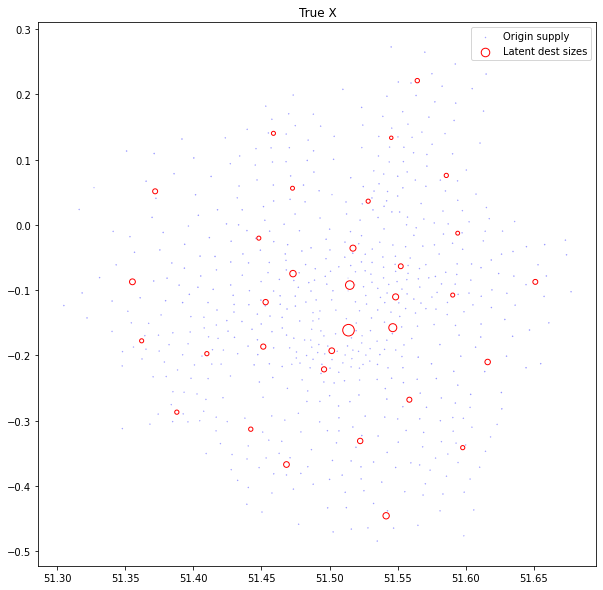

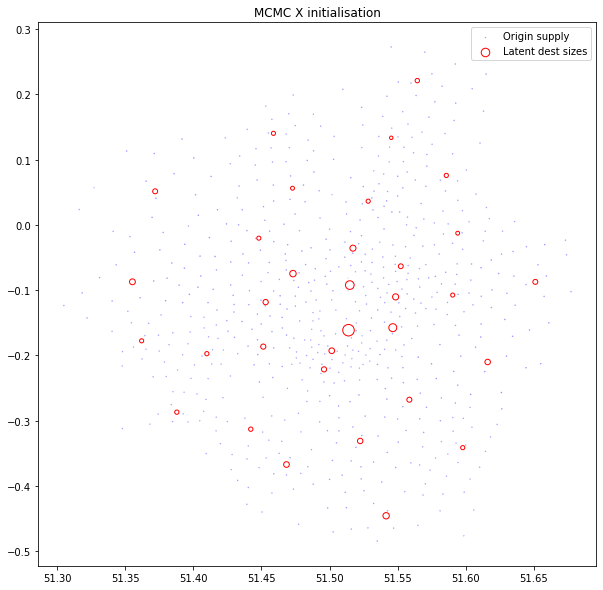

In [25]:
xx = x_high_init[mcmc_start]

plt.figure(0,figsize=(10,10))
plt.title("True X")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xd),label='Latent dest sizes')
plt.legend()

plt.figure(1,figsize=(10,10))
plt.title("MCMC X initialisation")
plt.scatter(origin_locs[:, 1], origin_locs[:, 0], color='w',edgecolors='b',s=100*o, alpha=0.5,label='Origin supply')
plt.scatter(destination_locs[:, 1], destination_locs[:, 0], color='w',edgecolors='r', s=1000*np.exp(xx),label='Latent dest sizes')
plt.legend()

## Sign initialisations

In [26]:
positives = sign_high_init[sign_high_init>0].shape[0]
print(int(100*positives/n),'% positives')

print(sign_high_init)

87 % positives
[ 1.  1.  1. ... -1. -1. -1.]


# Export initilisations

In [27]:
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples{cost_matrix_file}_initial.txt"),theta_high_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples{cost_matrix_file}_initial.txt"),x_high_init)
np.savetxt(os.path.join(wd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples{cost_matrix_file}_initial.txt"),sign_high_init)